# **Modelling 1 : XGBoost and Adaboost**

In [1]:
## Uncomment the below lines to install the packages if they aren't already

# ! pip install yellowbrick
# ! pip install missingno
# ! pip install xgboost 
# ! pip install shap

     |████████████████████████████████| 274 kB 30.0 MB/s 
     |████████████████████████████████| 564 kB 16.1 MB/s 


In [3]:
# Importing packages 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    auc, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve, 
    accuracy_score, 
    precision_score, 
    average_precision_score, 
    recall_score, 
    f1_score, 
    precision_recall_curve, 
    cohen_kappa_score, 
    confusion_matrix, 
    classification_report
)

from yellowbrick.classifier import ConfusionMatrix, ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from sklearn.dummy import DummyClassifier

import xgboost as xgb
 
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ClassificationReport
from yellowbrick.model_selection import FeatureImportances


import shap

from sklearn.ensemble import AdaBoostClassifier

from yellowbrick.classifier import (
    ConfusionMatrix,
    ROCAUC
)

from sklearn.model_selection import GridSearchCV

## **Data acquisition**

In [5]:
# Reading the train file
train = pd.read_csv("Fraud_sampledtrain.csv")

# Reading the val file
val = pd.read_csv("Fraud_val.csv")

# Reading the test file
test = pd.read_csv("Fraud_test.csv")

#fraud_labels = fraud["FraudFound_P"].copy()
#fraud = fraud.drop("FraudFound_P", axis=1)


## **Data Summary and Preprocessing**

In [6]:
# Drop unwanted columns and split into X(features) and Y(target) across all the 3 dataframes 

train.drop("Unnamed: 0", inplace= True, axis=1)
y_train= train["FraudFound_P"]
X_train = train.drop("FraudFound_P", axis=1)

val.drop("Unnamed: 0", inplace= True, axis=1)
y_val= val["FraudFound_P"]
X_val = val.drop("FraudFound_P", axis=1)

test.drop("Unnamed: 0", inplace= True, axis=1)
y_test= test["FraudFound_P"]
X_test = test.drop("FraudFound_P", axis=1)

In [7]:
# Plot precision recall curve

def plot_pr_curve(precision, recall, average_precision, clf):
    viz = PrecisionRecallCurve(clf, is_fitted=True)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()

In [8]:
# Plot ROC curve

def plot_roc_curve(fpr, tpr, roc_auc, clf):
  classes = ["0", "1"]

  visualizer = ROCAUC(
      clf, classes=classes, is_fitted=True
  )

  visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
  visualizer.score(X_test, y_test)        # Evaluate the model on the test data
  visualizer.show()  

In [9]:
# Calculate performance metrics

def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

    elif train == False:
        print("Validation Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_val, clf.predict(X_val))))
        
        precision, recall, _ = precision_recall_curve(y_val, clf.predict(X_val))
        average_precision = average_precision_score(y_val, clf.predict(X_val))
        plot_pr_curve(precision, recall, average_precision, clf)
        
        fpr, tpr, _ = roc_curve(y_val, clf.predict(X_val))
        roc_auc = roc_auc_score(y_val, clf.predict(X_val))
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc, clf)
        
        print("Classification Report: \n {}\n".format(classification_report(y_val, clf.predict(X_val))))
        print("End of validation Result\n")

## **Baseline model Dummy Classifier**


We use a baseline model which is a Dummy Classifier in our case to evaluate our models' performance against a common base score or a parameter.

In [10]:
# Creating a dummy classifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)

DummyClassifier()

Validation Result:

accuracy score: 0.0598



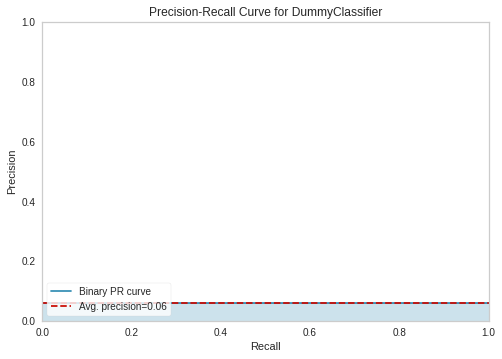

roc auc score: 0.5



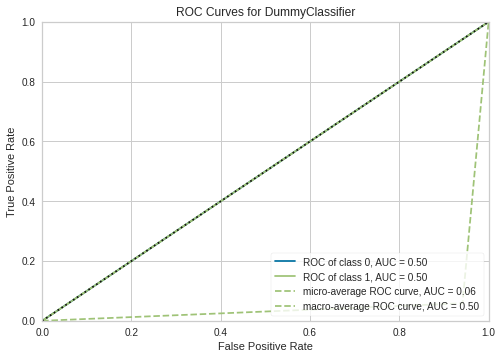

Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2090
           1       0.06      1.00      0.11       133

    accuracy                           0.06      2223
   macro avg       0.03      0.50      0.06      2223
weighted avg       0.00      0.06      0.01      2223


End of validation Result



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [11]:
clf_score(dummy_clf, X_train, y_train, X_val, y_val, train=False)

### Based on the above result, the base performance metrics have resulted in the following way:
### Accuracy= 5% => Thats a very low accuracy 
### ROC auc score = 0.5 => which means the clear dileanation between the proportion of the negative classes got incorrectly classified and the proportion of the positive classes got correctly classified. In our case, it has resulted in an average score of 0.5 which isn't great nor worst either.
### Precision: 6%
### Recall: 100% 

## **XGBoost Classifier**

In [49]:
# Create a XBGClassifier and train the model. 

clf_xgb = xgb.XGBClassifier(eta=0.01, max_depth = 4, min_child_weight=1, n_estimators= 50, random_state=0)  # Chosen model parameters based on the hyperparameter tuning results
clf_xgb.fit(X_train, y_train)

XGBClassifier(eta=0.01, max_depth=4, n_estimators=50)

Validation Result:

accuracy score: 0.6244



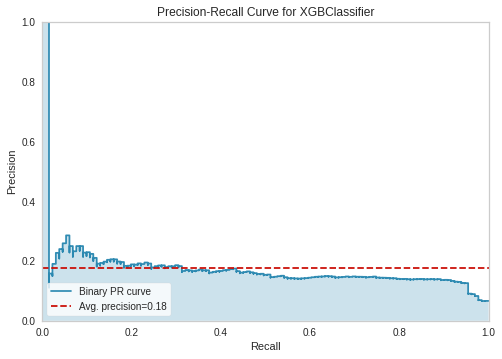

roc auc score: 0.7650375939849624



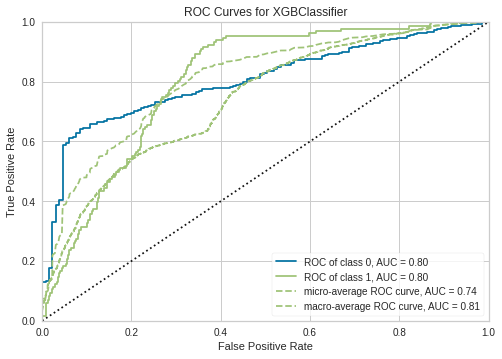

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.61      0.75      2090
           1       0.13      0.92      0.23       133

    accuracy                           0.62      2223
   macro avg       0.56      0.77      0.49      2223
weighted avg       0.94      0.62      0.72      2223


End of validation Result



In [50]:
# Performance metrics of the model

clf_score(clf_xgb, X_train, y_train, X_val, y_val, train=False)

### **Confusion Matrix** (Enlarged)

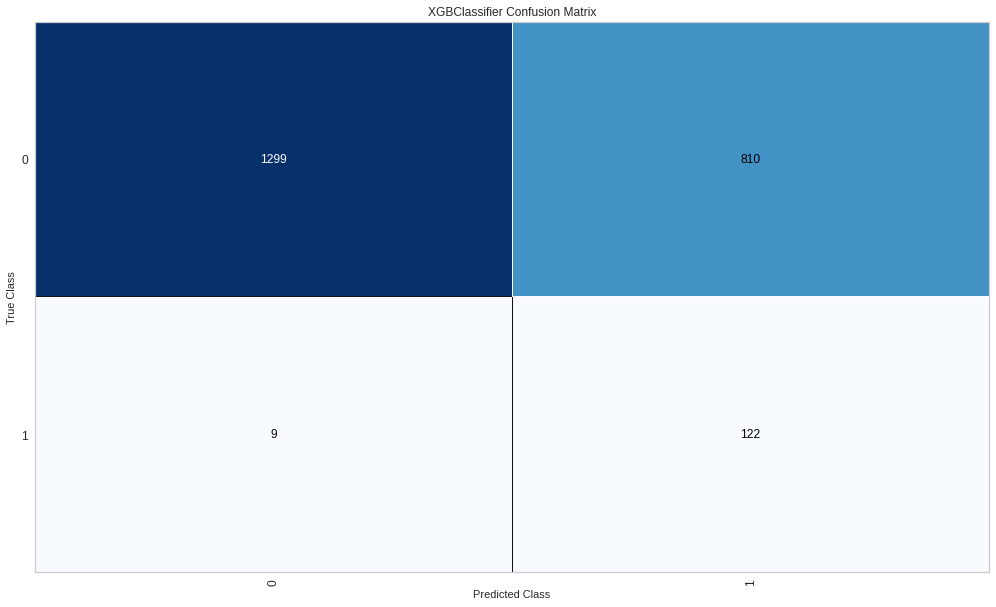

In [43]:

fig = plt.figure(figsize=(14, 8.6))

# The ConfusionMatrix visualizer 
cm = ConfusionMatrix(clf_xgb, classes=[0,1], is_fitted=True, cmap="Blues") 

# Fitting the passed model
cm.fit(X_train, y_train)

# Score runs predict() on the data and then creates the confusion_matrix from scikit-learn
cm.score(X_test, y_test)

cm.show()

### The above plot shows us that there are 1299 true negatives(the claim isnt fraudulent), 810 false positives(the claim isnt fraudulent but is predicted to be fraud), 9 false negatives(the claim isnt predicted to be fraudulent but in reality is) and 122 true positives(the claim is a fraud).

### **PR Curve** (Enlarged)

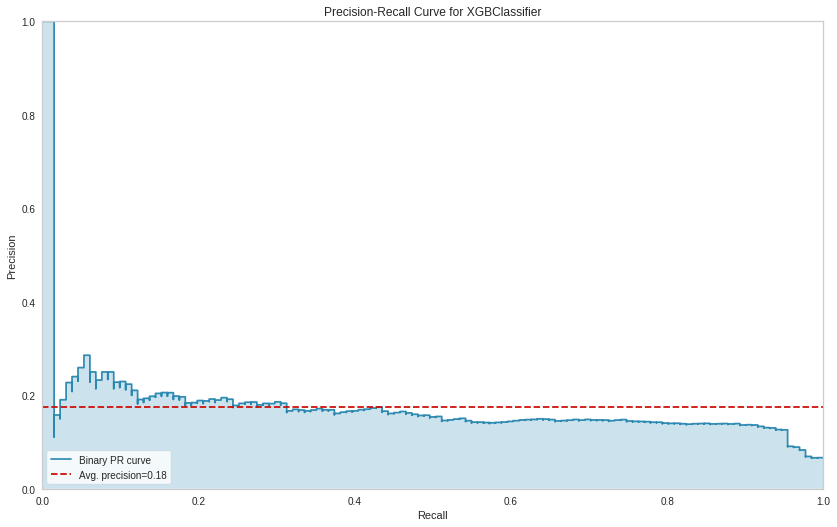

In [ ]:

viz = PrecisionRecallCurve(clf_xgb, is_fitted=True)
fig = plt.figure(figsize=(14, 8.6))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

### **ROC-AUC curve** (Enlarged)

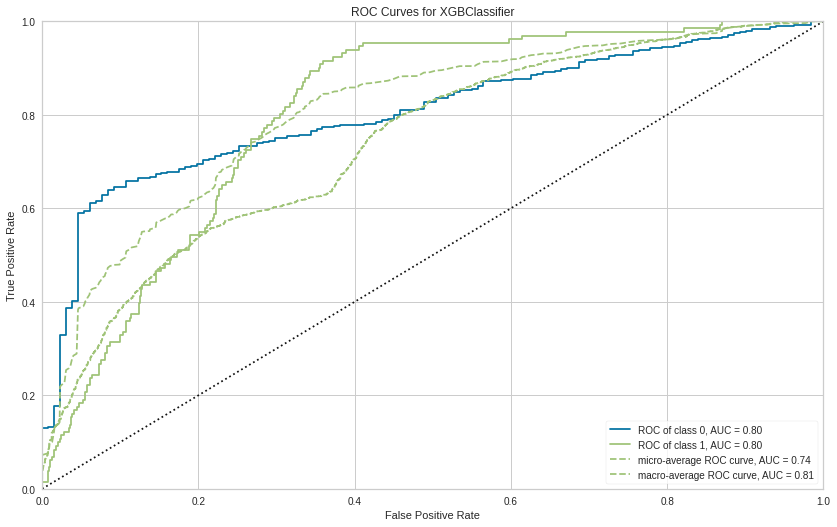

In [44]:
classes = ["0", "1"]

visualizer = ROCAUC(
    clf_xgb, classes=classes, is_fitted=True
)
fig = plt.figure(figsize=(14, 8.6))
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()  

### **Class prediction error**

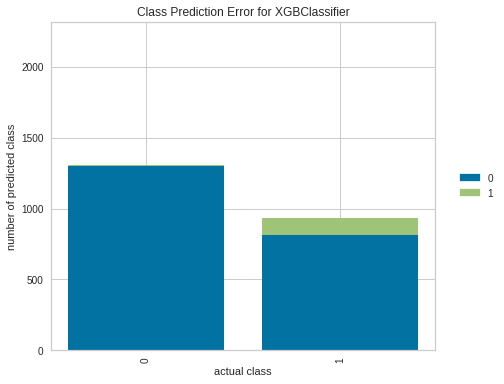

In [ ]:

classes = ["0", "1"]

visualizer = ClassPredictionError(
    clf_xgb, classes=classes, is_fitted=True
)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()

### **Classification Report**

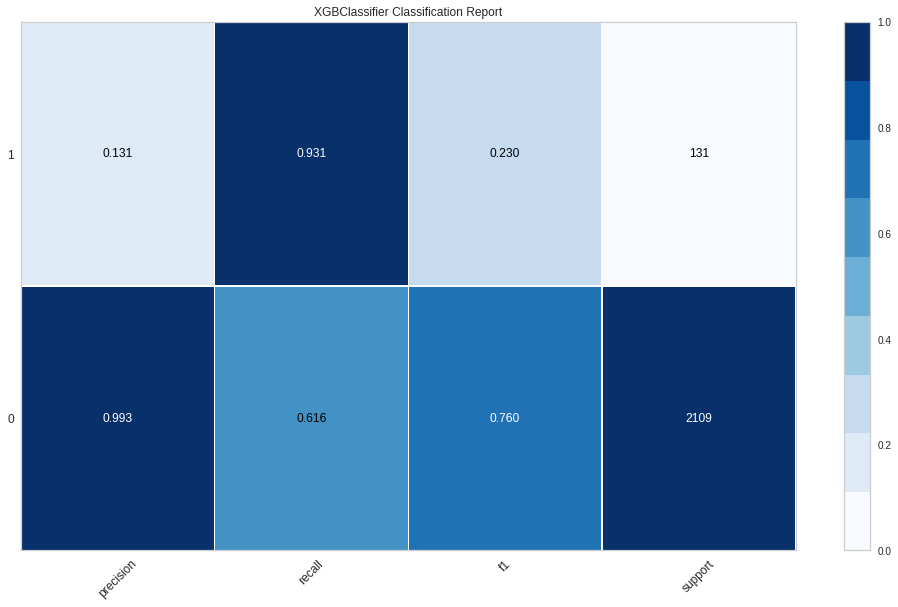

In [45]:

classes = ['0', '1']

visualizer = ClassificationReport(
    clf_xgb, classes=classes, support=True, is_fitted=True, cmap="Blues"
)
fig = plt.figure(figsize=(14, 8.6))
visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize a

### Based on the above results, XGBoost's performance metrics have resulted in the following way:
### Accuracy= 62% 
### ROC auc score = 0.76 => which means there is a 76% confidence level of a clear dileanation between the proportion of the negative classes got incorrectly classified and the proportion of the positive classes got correctly classified. In our case, it has resulted in an average score of 0.5 which isn't great nor worst either.
### Precision: 13% => Focuses more on false positives i.e., focuses more on a claim that isnt fraudulent, but has been predicted to be one
### Recall: 92% => Focuses more on flase negatives i.e, a claim that is fraudulent but hasnt been predicted as one. 


### **Feature Importance**

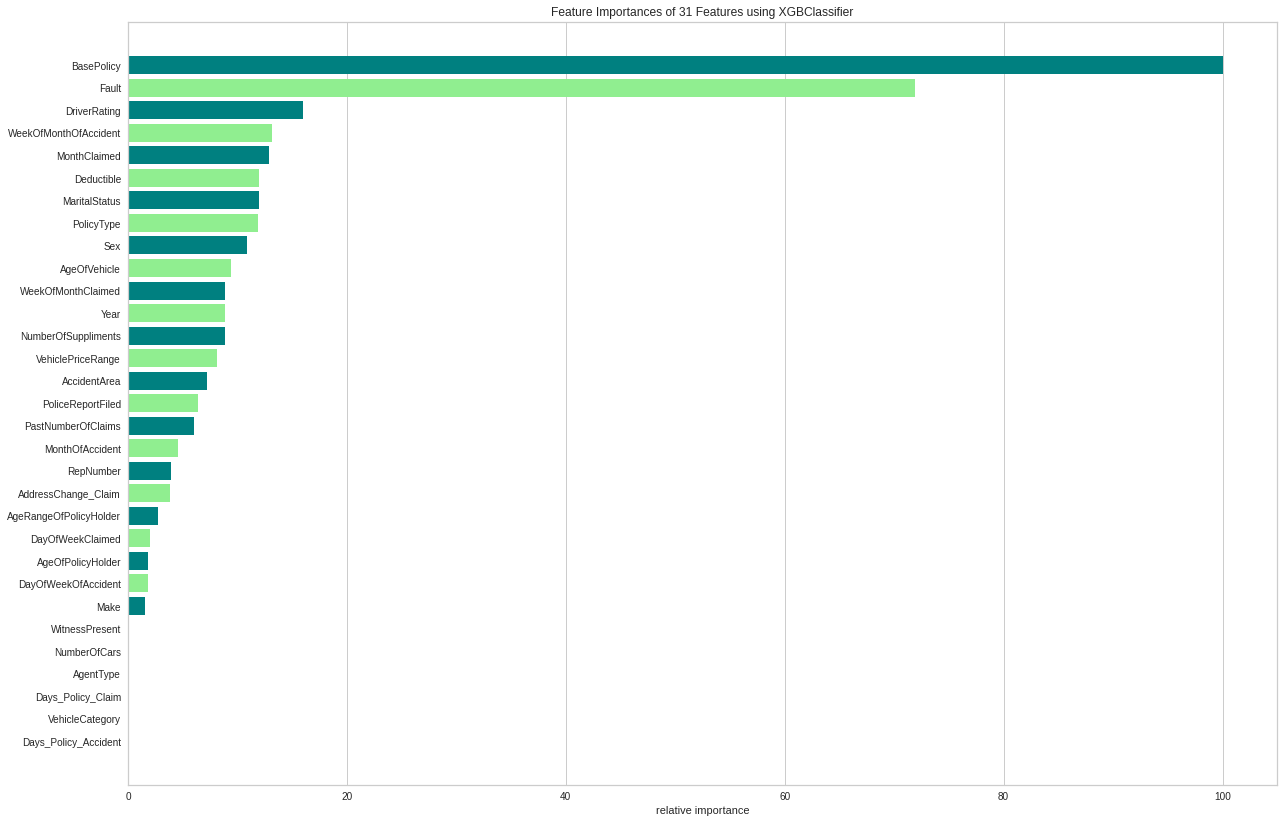

In [ ]:

fig = plt.figure(figsize=(18, 11.6))
viz = FeatureImportances(clf_xgb, labels=X_train.columns, colors=["teal", "lightgreen"])
viz.fit(X_train, y_train)

viz.poof()

### BasePolicy and Fault seem to be the primary contributors in determining the outoput of a claim being fraudulent or not.

### **Shapeley values**

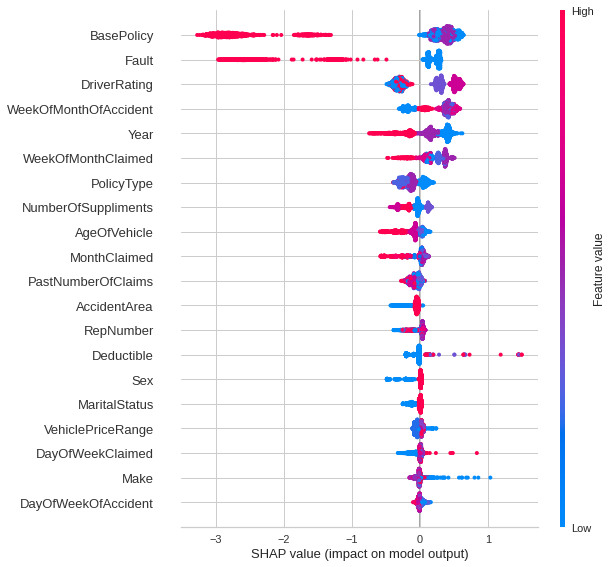

In [ ]:

fig = plt.figure(figsize=(14, 8.6))
explainer = shap.TreeExplainer(clf_xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

### Base Policy and Fault seem to have a high negative influence on the output to a very high extent. Similarly, Year, month and the Week that the insurance was claimed, age of the vehicle seem to have a high negative influence on the output but to a mild extent.In contrast, Week of the accident seems to have a slightly positively influence on the output. 

### **Hyperparameter Tuning**

In [46]:
# Automatically tune  hyperparameters (find optimal values) by using Grid Search


hyperparameter_space = {'n_estimators':[50, 100, 200], 
                        'eta':[ 0.01, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.5],
                        'max_depth': [4,5,6],
                        'min_child_weight': [1,2],
                        }



gs = GridSearchCV(xgb.XGBClassifier(
                                     random_state=0),
                  param_grid=hyperparameter_space, 
                   n_jobs=-1, cv=5)

gs.fit(X_train, y_train)
print("Optimal hyperparameter combination:", gs.best_params_)

Optimal hyperparameter combination: {'eta': 0.01, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 200}
